### Importing all the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from tabulate import tabulate

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

### Read the data

In [2]:
countries = pd.read_csv('Country-data.csv')
countries.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


### Checking the shape of the dataframe

In [3]:
countries.shape

(167, 10)

### Data Quality Checks

In [4]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [5]:
countries.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

#### Since the data for 'exports', 'health' and 'imports' are in percentage of 'gdpp', so those are required to be converted to their actual values

In [6]:
countries['exports'] = 0.01 * countries['exports'] * countries['gdpp']
countries['imports'] = 0.01 * countries['imports'] * countries['gdpp']
countries['health'] = 0.01 * countries['health'] * countries['gdpp']

In [7]:
countries.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


### Sanity Check

In [8]:
# Checking if there any duplicate entries for a country

countries[countries.duplicated(subset=['country'])].index.values

array([], dtype=int64)

#### Deriving a new feature - Trade Deficit

In [9]:
countries['Trade Deficit'] = countries['imports'] - countries['exports']

In [10]:
# Since the impacts of the columns 'exports' and 'imports' have already been considered in the new feature - 'Trade Deficit',
# hence dropping those 2 columns

countries.drop(['exports','imports'], axis = 1, inplace = True)
countries.shape

(167, 9)

In [11]:
countries.head()

,country,child_mort,health,income,inflation,life_expec,total_fer,gdpp,Trade Deficit
0,Afghanistan,90.2,41.9174,1610,9.44,56.2,5.82,553,192.997
1,Albania,16.6,267.8950,9930,4.49,76.3,1.65,4090,842.540
2,Algeria,27.3,185.9820,12900,16.10,76.5,2.89,4460,-312.200
3,Angola,119.0,100.6050,5900,22.40,60.1,6.16,3530,-684.820
4,Antigua and Barbuda,10.3,735.6600,19100,1.44,76.8,2.13,12200,1634.800


#### Statistical summary of the data

In [12]:
countries.describe()

,child_mort,health,income,inflation,life_expec,total_fer,gdpp,Trade Deficit
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,1056.733204,17144.688623,7.781832,70.555689,2.947964,12964.155689,-832.266739
std,40.328931,1801.408906,19278.067698,10.570704,8.893172,1.513848,18328.704809,4142.403188
min,2.600000,12.821200,609.000000,-4.210000,32.100000,1.150000,231.000000,-34650.000000
25%,8.250000,78.535500,3355.000000,1.810000,65.300000,1.795000,1330.000000,-327.050000
50%,19.300000,321.886000,9960.000000,5.390000,73.100000,2.410000,4660.000000,89.218200
75%,62.100000,976.940000,22800.000000,10.750000,76.800000,3.880000,14050.000000,518.570000
max,208.000000,8663.600000,125000.000000,104.000000,82.800000,7.490000,105000.000000,2436.000000


### Univariate Analysis & Outlier Treatment

In [13]:
# Function to print the dataframe in a tabular format
def tab(ser) : 
    print(tabulate(pd.DataFrame(ser), headers='keys', tablefmt='psql'))

In [14]:
# function to perform outlier analysis 
def outlier_analysis(column) : 
    '''
    This function displays a box plot of the column provided.
    It also prints the five major quantiles, lower oultier threshold value, upper outlier threshold value, 
    tables of countries which are outliers 
    Output : lower outlier threshold condition, upper outlier threshold condition
    Input : column name 
    Side effects : Box plot, Outlier tables
    '''
    plt.figure(figsize=[12,6])
    plt.title('Box Plot of '+column)
    sns.boxplot(countries[column])

    print('Quantiles\n')
    print(tab(countries[column].quantile([0.01,0.25,0.50,0.75,0.99])))

    lower_outlier_threshold = countries[column].quantile(0.01)
    upper_outlier_threshold = countries[column].quantile(0.99)

    print('\n\nLOWER OUTLIER THRESHOLD [1st PERCENTILE] FOR' ,column,': ',lower_outlier_threshold)
    l_condition = countries[column] < lower_outlier_threshold 
    l_outliers = countries[l_condition][['country',column]].sort_values(by=column)
   
    if l_outliers.shape[0] : 
        print('\n\nLower Outliers : ')
        tab(l_outliers)
    else : 
        print('No lower outliers found in ' + column)

    print('\n\nUPPER OUTLIER THRESHOLD [99th PERCENTILE] FOR' ,column,': ',upper_outlier_threshold)
    u_condition = countries[column] > upper_outlier_threshold 
    u_outliers = countries[u_condition][['country',column]].sort_values(by=column)

    if u_outliers.shape[0] : 
        print('\n\nUpper Outliers : ')
        tab(u_outliers)
        print('\n\n')

    return l_condition, u_condition


#### Child Mortality

Quantiles

+------+--------------+
|      |   child_mort |
|------+--------------|
| 0.01 |         2.8  |
| 0.25 |         8.25 |
| 0.5  |        19.3  |
| 0.75 |        62.1  |
| 0.99 |       153.4  |
+------+--------------+
None


LOWER OUTLIER THRESHOLD [1st PERCENTILE] FOR child_mort :  2.8


Lower Outliers : 
+----+-----------+--------------+
|    | country   |   child_mort |
|----+-----------+--------------|
| 68 | Iceland   |          2.6 |
+----+-----------+--------------+


UPPER OUTLIER THRESHOLD [99th PERCENTILE] FOR child_mort :  153.40000000000003


Upper Outliers : 
+-----+--------------+--------------+
|     | country      |   child_mort |
|-----+--------------+--------------|
| 132 | Sierra Leone |          160 |
|  66 | Haiti        |          208 |
+-----+--------------+--------------+





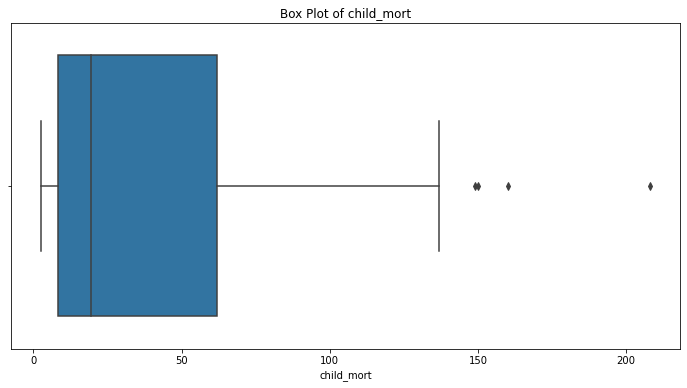

In [15]:
# Countries with oultiers in child mortality 
column = 'child_mort'
l_condition, u_condition = outlier_analysis(column)

In [16]:
# Capping countries with lower outliers for 'child_mort'
countries.loc[l_condition, column] = countries[column].quantile(0.01)

### Health Spending

Quantiles

+------+-----------+
|      |    health |
|------+-----------|
| 0.01 |   17.0094 |
| 0.25 |   78.5355 |
| 0.5  |  321.886  |
| 0.75 |  976.94   |
| 0.99 | 8410.33   |
+------+-----------+
None


LOWER OUTLIER THRESHOLD [1st PERCENTILE] FOR health :  17.009362000000003


Lower Outliers : 
+----+------------+----------+
|    | country    |   health |
|----+------------+----------|
| 50 | Eritrea    |  12.8212 |
| 93 | Madagascar |  15.5701 |
+----+------------+----------+


UPPER OUTLIER THRESHOLD [99th PERCENTILE] FOR health :  8410.3304


Upper Outliers : 
+-----+---------------+----------+
|     | country       |   health |
|-----+---------------+----------|
| 145 | Switzerland   |   8579   |
| 159 | United States |   8663.6 |
+-----+---------------+----------+





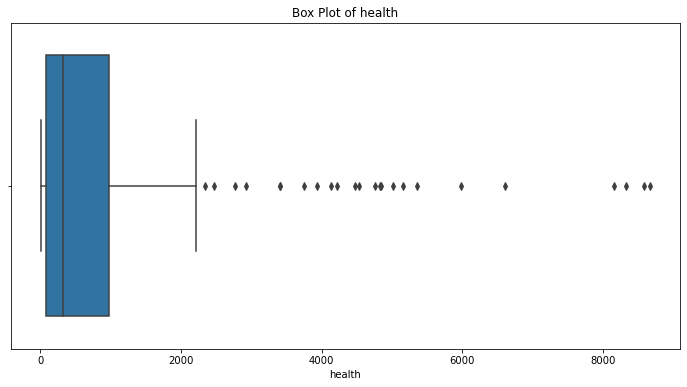

In [17]:
# Countries with outliers in health spending
column = 'health'
l_condition, u_condition = outlier_analysis(column)

In [18]:
# Capping countries with upper outliers in health spending 
countries.loc[u_condition,column] = countries[column].quantile(0.99)

#### Net Income per person

Quantiles

+------+----------+
|      |   income |
|------+----------|
| 0.01 |   742.24 |
| 0.25 |  3355    |
| 0.5  |  9960    |
| 0.75 | 22800    |
| 0.99 | 84374    |
+------+----------+
None


LOWER OUTLIER THRESHOLD [1st PERCENTILE] FOR income :  742.24


Lower Outliers : 
+----+------------------+----------+
|    | country          |   income |
|----+------------------+----------|
| 37 | Congo, Dem. Rep. |      609 |
| 88 | Liberia          |      700 |
+----+------------------+----------+


UPPER OUTLIER THRESHOLD [99th PERCENTILE] FOR income :  84374.00000000003


Upper Outliers : 
+-----+------------+----------+
|     | country    |   income |
|-----+------------+----------|
|  91 | Luxembourg |    91700 |
| 123 | Qatar      |   125000 |
+-----+------------+----------+





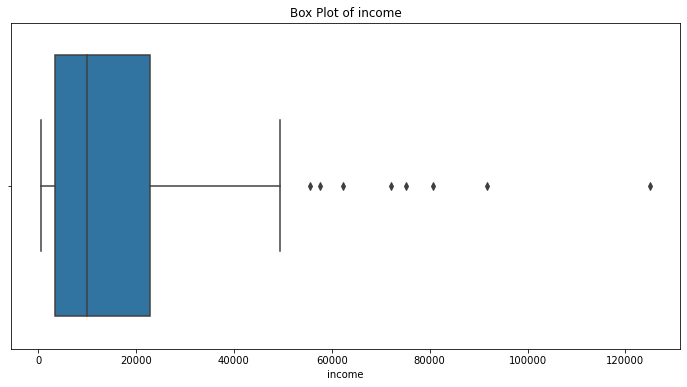

In [19]:
column = 'income'
l_condition, u_condition = outlier_analysis(column)

In [20]:
# Capping countries with upper outliers for 'income'
countries.loc[u_condition,column] = countries[column].quantile(0.99)

#### Inflation

Quantiles

+------+-------------+
|      |   inflation |
|------+-------------|
| 0.01 |     -2.3488 |
| 0.25 |      1.81   |
| 0.5  |      5.39   |
| 0.75 |     10.75   |
| 0.99 |     41.478  |
+------+-------------+
None


LOWER OUTLIER THRESHOLD [1st PERCENTILE] FOR inflation :  -2.3487999999999998


Lower Outliers : 
+-----+------------+-------------+
|     | country    |   inflation |
|-----+------------+-------------|
| 131 | Seychelles |       -4.21 |
|  73 | Ireland    |       -3.22 |
+-----+------------+-------------+


UPPER OUTLIER THRESHOLD [99th PERCENTILE] FOR inflation :  41.47800000000002


Upper Outliers : 
+-----+-----------+-------------+
|     | country   |   inflation |
|-----+-----------+-------------|
| 163 | Venezuela |        45.9 |
| 113 | Nigeria   |       104   |
+-----+-----------+-------------+





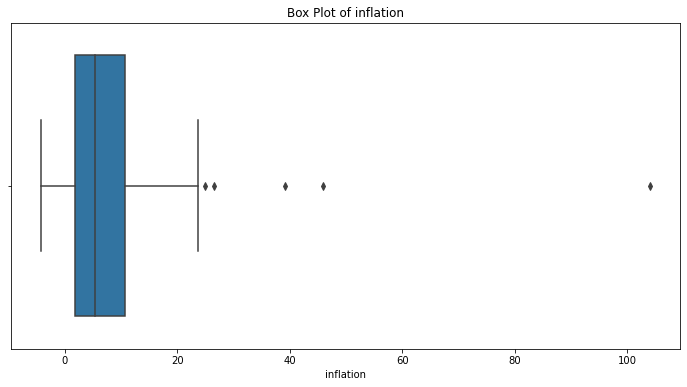

In [21]:
column = 'inflation'
l_condition, u_condition = outlier_analysis(column)

In [22]:
# Capping countries with lower outliers for 'inflation'
countries.loc[l_condition, column] = countries[column].quantile(0.01)

#### Life Expectancy

Quantiles

+------+--------------+
|      |   life_expec |
|------+--------------|
| 0.01 |        47.16 |
| 0.25 |        65.3  |
| 0.5  |        73.1  |
| 0.75 |        76.8  |
| 0.99 |        82.37 |
+------+--------------+
None


LOWER OUTLIER THRESHOLD [1st PERCENTILE] FOR life_expec :  47.160000000000004


Lower Outliers : 
+----+-----------+--------------+
|    | country   |   life_expec |
|----+-----------+--------------|
| 66 | Haiti     |         32.1 |
| 87 | Lesotho   |         46.5 |
+----+-----------+--------------+


UPPER OUTLIER THRESHOLD [99th PERCENTILE] FOR life_expec :  82.37


Upper Outliers : 
+-----+-----------+--------------+
|     | country   |   life_expec |
|-----+-----------+--------------|
| 133 | Singapore |         82.7 |
|  77 | Japan     |         82.8 |
+-----+-----------+--------------+





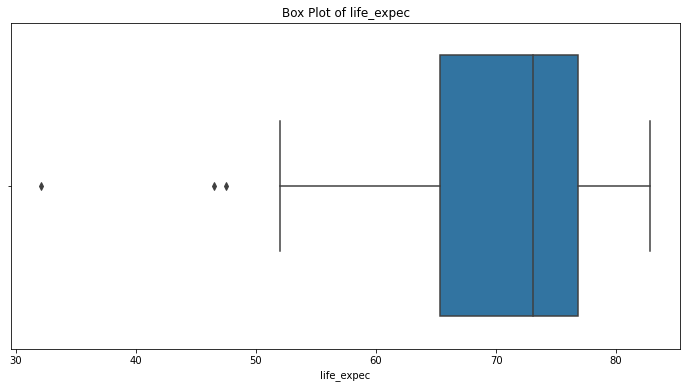

In [23]:
column = 'life_expec'
l_condition, u_condition = outlier_analysis(column)

In [24]:
# Capping countries with upper outliers for 'life_expec'
countries.loc[u_condition,column] = countries[column].quantile(0.99)

#### Fertility

Quantiles

+------+-------------+
|      |   total_fer |
|------+-------------|
| 0.01 |      1.2432 |
| 0.25 |      1.795  |
| 0.5  |      2.41   |
| 0.75 |      3.88   |
| 0.99 |      6.5636 |
+------+-------------+
None


LOWER OUTLIER THRESHOLD [1st PERCENTILE] FOR total_fer :  1.2431999999999999


Lower Outliers : 
+-----+-------------+-------------+
|     | country     |   total_fer |
|-----+-------------+-------------|
| 133 | Singapore   |        1.15 |
| 138 | South Korea |        1.23 |
+-----+-------------+-------------+


UPPER OUTLIER THRESHOLD [99th PERCENTILE] FOR total_fer :  6.563599999999999


Upper Outliers : 
+-----+-----------+-------------+
|     | country   |   total_fer |
|-----+-----------+-------------|
|  32 | Chad      |        6.59 |
| 112 | Niger     |        7.49 |
+-----+-----------+-------------+





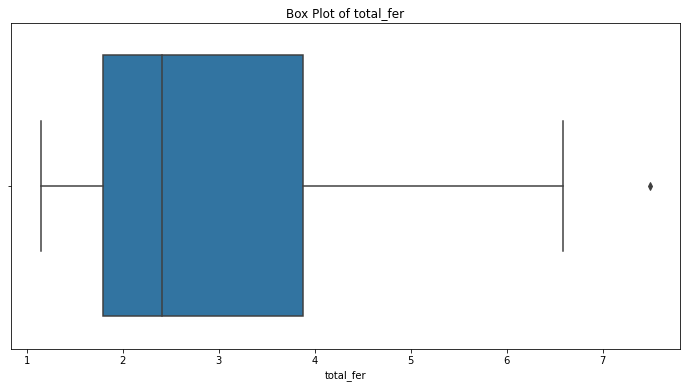

In [25]:
column = 'total_fer'
l_condition, u_condition = outlier_analysis(column)

In [26]:
# Capping countries with lower outliers for 'total_fer'
countries.loc[l_condition, column] = countries[column].quantile(0.01)

#### GDP

Quantiles

+------+----------+
|      |     gdpp |
|------+----------|
| 0.01 |   331.62 |
| 0.25 |  1330    |
| 0.5  |  4660    |
| 0.75 | 14050    |
| 0.99 | 79088    |
+------+----------+
None


LOWER OUTLIER THRESHOLD [1st PERCENTILE] FOR gdpp :  331.62


Lower Outliers : 
+----+-----------+--------+
|    | country   |   gdpp |
|----+-----------+--------|
| 26 | Burundi   |    231 |
| 88 | Liberia   |    327 |
+----+-----------+--------+


UPPER OUTLIER THRESHOLD [99th PERCENTILE] FOR gdpp :  79088.00000000004


Upper Outliers : 
+-----+------------+--------+
|     | country    |   gdpp |
|-----+------------+--------|
| 114 | Norway     |  87800 |
|  91 | Luxembourg | 105000 |
+-----+------------+--------+





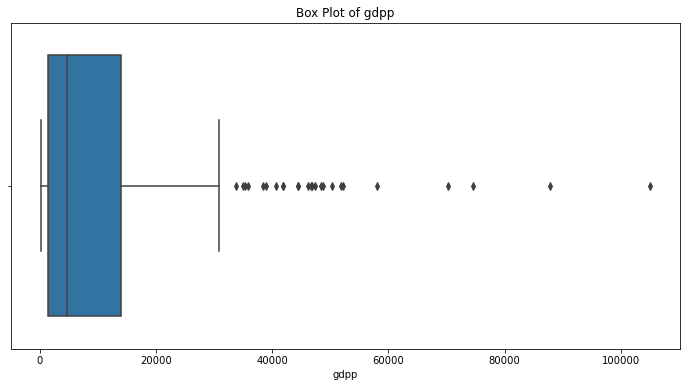

In [27]:
column = 'gdpp'
l_condition, u_condition = outlier_analysis(column)

In [28]:
# Capping countries with upper outliers for 'gdpp'
countries.loc[u_condition,column] = countries[column].quantile(0.99)

#### Trade Deficit

Quantiles

+------+-----------------+
|      |   Trade Deficit |
|------+-----------------|
| 0.01 |     -18426.1    |
| 0.25 |       -327.05   |
| 0.5  |         89.2182 |
| 0.75 |        518.57   |
| 0.99 |       2270.5    |
+------+-----------------+
None


LOWER OUTLIER THRESHOLD [1st PERCENTILE] FOR Trade Deficit :  -18426.1


Lower Outliers : 
+-----+------------+-----------------+
|     | country    |   Trade Deficit |
|-----+------------+-----------------|
|  91 | Luxembourg |        -34650   |
| 123 | Qatar      |        -27065.5 |
+-----+------------+-----------------+


UPPER OUTLIER THRESHOLD [99th PERCENTILE] FOR Trade Deficit :  2270.500000000002


Upper Outliers : 
+----+-----------+-----------------+
|    | country   |   Trade Deficit |
|----+-----------+-----------------|
| 60 | Greece    |          2313.4 |
| 10 | Bahamas   |          2436   |
+----+-----------+-----------------+





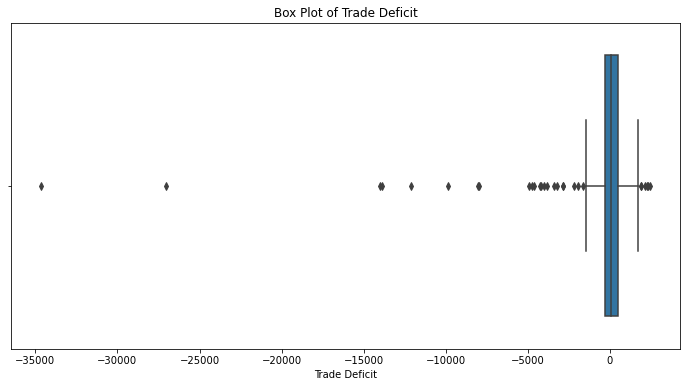

In [29]:
column = 'Trade Deficit'
l_condition, u_condition = outlier_analysis(column)

In [30]:
# Capping countries with lower outliers for 'Trade Deficit'
countries.loc[l_condition, column] = countries[column].quantile(0.01)

### Re-checking the statistical summary after the outlier treatment

In [31]:
countries.describe()

,child_mort,health,income,inflation,life_expec,total_fer,gdpp,Trade Deficit
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.271257,1054.206622,16857.550898,7.798194,70.551138,2.948601,12756.826347,-683.384703
std,40.327869,1790.845342,17957.012855,10.553699,8.886987,1.513108,17430.208938,3135.533161
min,2.800000,12.821200,609.000000,-2.348800,32.100000,1.243200,231.000000,-18426.100000
25%,8.250000,78.535500,3355.000000,1.810000,65.300000,1.795000,1330.000000,-327.050000
50%,19.300000,321.886000,9960.000000,5.390000,73.100000,2.410000,4660.000000,89.218200
75%,62.100000,976.940000,22800.000000,10.750000,76.800000,3.880000,14050.000000,518.570000
max,208.000000,8410.330400,84374.000000,104.000000,82.370000,7.490000,79088.000000,2436.000000


### Bivariate Analysis

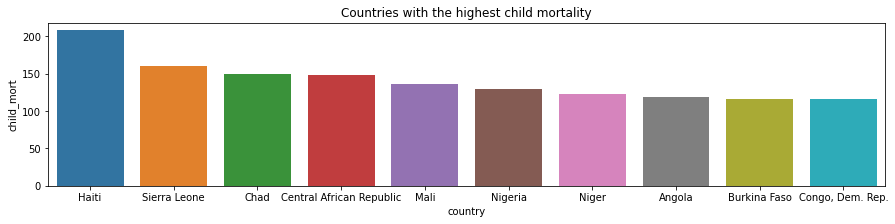

In [32]:
# Checking for the top 10 countries with the highest child mortality 

plt.figure(figsize = (15,3))
child_mortality = countries.sort_values(by = 'child_mort', ascending = False ).head(10)
plt.title('Countries with the highest child mortality')
sns.barplot('country','child_mort',data = child_mortality)
plt.show()

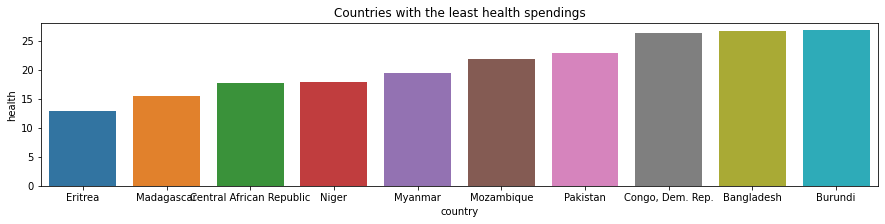

In [33]:
# Checking for the bottom 10 countries with the least health spendings

plt.figure(figsize = (15,3))
health = countries.sort_values(by = 'health', ascending = True ).head(10)
plt.title('Countries with the least health spendings')
sns.barplot('country','health',data = health)
plt.show()

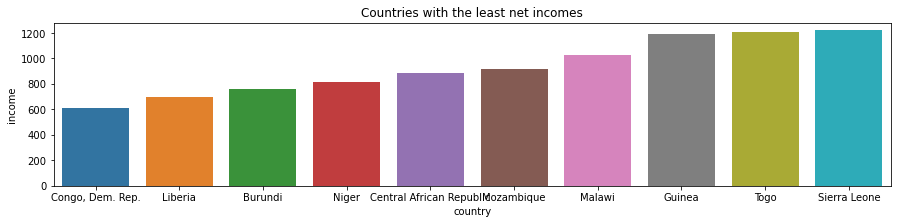

In [34]:
# Checking for the bottom 10 countries with the least net incomes

plt.figure(figsize = (15,3))
income = countries.sort_values(by = 'income', ascending = True ).head(10)
plt.title('Countries with the least net incomes')
sns.barplot('country','income',data = income)
plt.show()

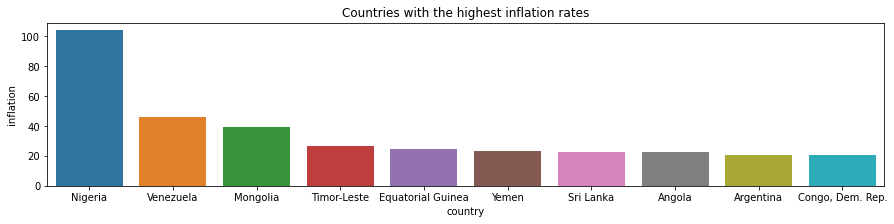

In [35]:
# Checking for the top 10 countries with the highest inflation rates 

plt.figure(figsize = (15,3))
inflation = countries.sort_values(by = 'inflation', ascending = False ).head(10)
plt.title('Countries with the highest inflation rates')
sns.barplot('country','inflation',data = inflation)
plt.show()

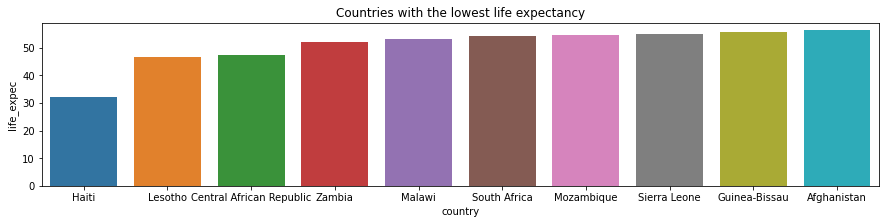

In [36]:
# Checking for the bottom 10 countries with the lowest life expectancy 

plt.figure(figsize = (15,3))
life = countries.sort_values(by = 'life_expec', ascending = True ).head(10)
plt.title('Countries with the lowest life expectancy')
sns.barplot('country','life_expec',data = life)
plt.show()

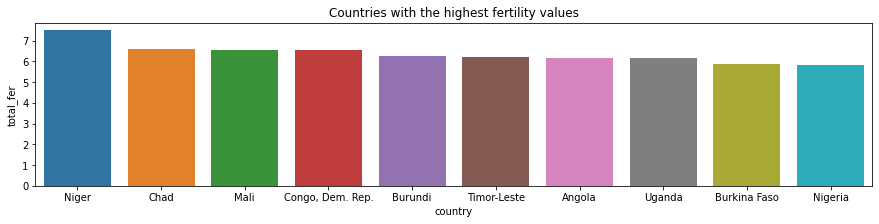

In [37]:
# Checking for the top 10 countries with the highest fertility values 

plt.figure(figsize = (15,3))
fert = countries.sort_values(by = 'total_fer', ascending = False ).head(10)
plt.title('Countries with the highest fertility values')
sns.barplot('country','total_fer',data = fert)
plt.show()

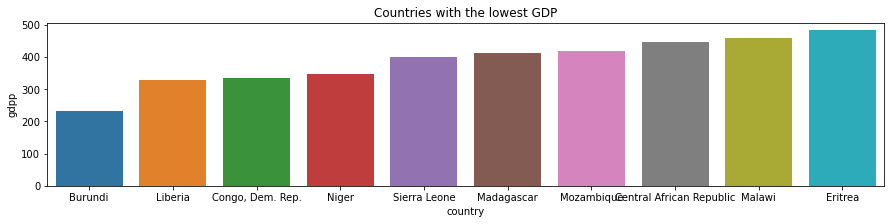

In [38]:
# Checking for the bottom 10 countries with the lowest GDP 

plt.figure(figsize = (15,3))
gdp = countries.sort_values(by = 'gdpp', ascending = True ).head(10)
plt.title('Countries with the lowest GDP')
sns.barplot('country','gdpp',data = gdp)
plt.show()

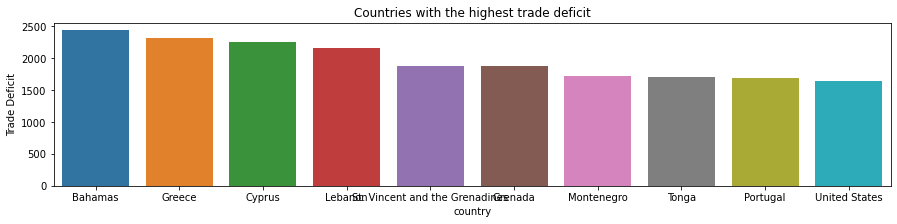

In [39]:
# Checking for the top 10 countries with the highest trade deficit 

plt.figure(figsize = (15,3))
trade_deficit = countries.sort_values(by = 'Trade Deficit', ascending = False ).head(10)
plt.title('Countries with the highest trade deficit')
sns.barplot('country','Trade Deficit',data = trade_deficit)
plt.show()

### Multivariate Analysis

In [40]:
# Countries with high child mortality and low health spendings

countries[['country','child_mort','health']].sort_values(by=['child_mort','health'], ascending=[False,True])[:10]

,country,child_mort,health
66,Haiti,208.0,45.7442
132,Sierra Leone,160.0,52.2690
32,Chad,150.0,40.6341
31,Central African Republic,149.0,17.7508
97,Mali,137.0,35.2584
113,Nigeria,130.0,118.1310
112,Niger,123.0,17.9568
3,Angola,119.0,100.6050
37,"Congo, Dem. Rep.",116.0,26.4194
25,Burkina Faso,116.0,38.7550


In [41]:
# Countries with high child mortality and low net income per person

countries[['country','child_mort','income']].sort_values(by=['child_mort','income'], ascending=[False,True])[:10]

,country,child_mort,income
66,Haiti,208.0,1500.0
132,Sierra Leone,160.0,1220.0
32,Chad,150.0,1930.0
31,Central African Republic,149.0,888.0
97,Mali,137.0,1870.0
113,Nigeria,130.0,5150.0
112,Niger,123.0,814.0
3,Angola,119.0,5900.0
37,"Congo, Dem. Rep.",116.0,609.0
25,Burkina Faso,116.0,1430.0


In [42]:
# Countries with high child mortality and high inflation rates

countries[['country','child_mort','inflation']].sort_values(by=['child_mort','inflation'], ascending=[False,False])[:10]

,country,child_mort,inflation
66,Haiti,208.0,5.45
132,Sierra Leone,160.0,17.20
32,Chad,150.0,6.39
31,Central African Republic,149.0,2.01
97,Mali,137.0,4.37
113,Nigeria,130.0,104.00
112,Niger,123.0,2.55
3,Angola,119.0,22.40
37,"Congo, Dem. Rep.",116.0,20.80
25,Burkina Faso,116.0,6.81


In [43]:
# Countries with high child mortality and low life expectancy

countries[['country','child_mort','life_expec']].sort_values(by=['child_mort','life_expec'], ascending=[False,True])[:10]

,country,child_mort,life_expec
66,Haiti,208.0,32.1
132,Sierra Leone,160.0,55.0
32,Chad,150.0,56.5
31,Central African Republic,149.0,47.5
97,Mali,137.0,59.5
113,Nigeria,130.0,60.5
112,Niger,123.0,58.8
3,Angola,119.0,60.1
37,"Congo, Dem. Rep.",116.0,57.5
25,Burkina Faso,116.0,57.9


In [44]:
# Countries with high child mortality and high fertility

countries[['country','child_mort','total_fer']].sort_values(by=['child_mort','total_fer'], ascending=[False,False])[:10]

,country,child_mort,total_fer
66,Haiti,208.0,3.33
132,Sierra Leone,160.0,5.20
32,Chad,150.0,6.59
31,Central African Republic,149.0,5.21
97,Mali,137.0,6.55
113,Nigeria,130.0,5.84
112,Niger,123.0,7.49
3,Angola,119.0,6.16
37,"Congo, Dem. Rep.",116.0,6.54
25,Burkina Faso,116.0,5.87


In [45]:
# Countries with high child mortality and low GDP

countries[['country','child_mort','gdpp']].sort_values(by=['child_mort','gdpp'], ascending=[False,True])[:10]

,country,child_mort,gdpp
66,Haiti,208.0,662.0
132,Sierra Leone,160.0,399.0
32,Chad,150.0,897.0
31,Central African Republic,149.0,446.0
97,Mali,137.0,708.0
113,Nigeria,130.0,2330.0
112,Niger,123.0,348.0
3,Angola,119.0,3530.0
37,"Congo, Dem. Rep.",116.0,334.0
25,Burkina Faso,116.0,575.0


In [46]:
# Countries with high child mortality and high trade deficit

countries[['country','child_mort','Trade Deficit']].sort_values(by=['child_mort','Trade Deficit'], ascending=[False,False])[:10]

,country,child_mort,Trade Deficit
66,Haiti,208.0,327.028
132,Sierra Leone,160.0,70.623
32,Chad,150.0,60.099
31,Central African Republic,149.0,65.562
97,Mali,137.0,87.084
113,Nigeria,130.0,-184.070
112,Niger,123.0,93.612
3,Angola,119.0,-684.820
25,Burkina Faso,116.0,59.800
37,"Congo, Dem. Rep.",116.0,28.390


In [47]:
# Countries with low income and low health spendings

countries[['country','income','health']].sort_values(by=['income','health'], ascending=[True,True])[:10]

,country,income,health
37,"Congo, Dem. Rep.",609.0,26.4194
88,Liberia,700.0,38.5860
26,Burundi,764.0,26.7960
112,Niger,814.0,17.9568
31,Central African Republic,888.0,17.7508
106,Mozambique,918.0,21.8299
94,Malawi,1030.0,30.2481
63,Guinea,1190.0,31.9464
150,Togo,1210.0,37.3320
132,Sierra Leone,1220.0,52.2690


In [48]:
# Countries with low income and high inflation rates

countries[['country','income','inflation']].sort_values(by=['income','inflation'], ascending=[True,False])[:10]

,country,income,inflation
37,"Congo, Dem. Rep.",609.0,20.80
88,Liberia,700.0,5.47
26,Burundi,764.0,12.30
112,Niger,814.0,2.55
31,Central African Republic,888.0,2.01
106,Mozambique,918.0,7.64
94,Malawi,1030.0,12.10
63,Guinea,1190.0,16.10
150,Togo,1210.0,1.18
132,Sierra Leone,1220.0,17.20


In [49]:
# Countries with low income and low life expectancy

countries[['country','income','life_expec']].sort_values(by=['income','life_expec'], ascending=[True,True])[:10]

,country,income,life_expec
37,"Congo, Dem. Rep.",609.0,57.5
88,Liberia,700.0,60.8
26,Burundi,764.0,57.7
112,Niger,814.0,58.8
31,Central African Republic,888.0,47.5
106,Mozambique,918.0,54.5
94,Malawi,1030.0,53.1
63,Guinea,1190.0,58.0
150,Togo,1210.0,58.7
132,Sierra Leone,1220.0,55.0


In [50]:
# Countries with low income and high ferility rates

countries[['country','income','total_fer']].sort_values(by=['income','total_fer'], ascending=[True,False])[:10]

,country,income,total_fer
37,"Congo, Dem. Rep.",609.0,6.54
88,Liberia,700.0,5.02
26,Burundi,764.0,6.26
112,Niger,814.0,7.49
31,Central African Republic,888.0,5.21
106,Mozambique,918.0,5.56
94,Malawi,1030.0,5.31
63,Guinea,1190.0,5.34
150,Togo,1210.0,4.87
132,Sierra Leone,1220.0,5.20


In [51]:
# Countries with low income and low gdp

countries[['country','income','gdpp']].sort_values(by=['income','gdpp'], ascending=[True,True])[:10]

,country,income,gdpp
37,"Congo, Dem. Rep.",609.0,334.0
88,Liberia,700.0,327.0
26,Burundi,764.0,231.0
112,Niger,814.0,348.0
31,Central African Republic,888.0,446.0
106,Mozambique,918.0,419.0
94,Malawi,1030.0,459.0
63,Guinea,1190.0,648.0
150,Togo,1210.0,488.0
132,Sierra Leone,1220.0,399.0


In [52]:
# Countries with low income and high trade deficit

countries[['country','income','Trade Deficit']].sort_values(by=['income','Trade Deficit'], ascending=[True,False])[:10]

,country,income,Trade Deficit
37,"Congo, Dem. Rep.",609.0,28.3900
88,Liberia,700.0,240.3450
26,Burundi,764.0,69.9468
112,Niger,814.0,93.6120
31,Central African Republic,888.0,65.5620
106,Mozambique,918.0,61.5930
94,Malawi,1030.0,55.5390
63,Guinea,1190.0,83.5920
150,Togo,1210.0,83.4480
132,Sierra Leone,1220.0,70.6230


In [53]:
# Countries with low gdp and low health spendings

countries[['country','gdpp','health']].sort_values(by=['gdpp','health'], ascending=[True,True])[:10]

,country,gdpp,health
26,Burundi,231.0,26.7960
88,Liberia,327.0,38.5860
37,"Congo, Dem. Rep.",334.0,26.4194
112,Niger,348.0,17.9568
132,Sierra Leone,399.0,52.2690
93,Madagascar,413.0,15.5701
106,Mozambique,419.0,21.8299
31,Central African Republic,446.0,17.7508
94,Malawi,459.0,30.2481
50,Eritrea,482.0,12.8212


In [54]:
# Countries with low gdp and high inflation rate

countries[['country','gdpp','inflation']].sort_values(by=['gdpp','inflation'], ascending=[True,False])[:10]

,country,gdpp,inflation
26,Burundi,231.0,12.30
88,Liberia,327.0,5.47
37,"Congo, Dem. Rep.",334.0,20.80
112,Niger,348.0,2.55
132,Sierra Leone,399.0,17.20
93,Madagascar,413.0,8.79
106,Mozambique,419.0,7.64
31,Central African Republic,446.0,2.01
94,Malawi,459.0,12.10
50,Eritrea,482.0,11.60


In [55]:
# Countries with low gdp and low life expectancy

countries[['country','gdpp','life_expec']].sort_values(by=['gdpp','life_expec'], ascending=[True,True])[:10]

,country,gdpp,life_expec
26,Burundi,231.0,57.7
88,Liberia,327.0,60.8
37,"Congo, Dem. Rep.",334.0,57.5
112,Niger,348.0,58.8
132,Sierra Leone,399.0,55.0
93,Madagascar,413.0,60.8
106,Mozambique,419.0,54.5
31,Central African Republic,446.0,47.5
94,Malawi,459.0,53.1
50,Eritrea,482.0,61.7


In [56]:
# Countries with low gdp and high fertility rate

countries[['country','gdpp','total_fer']].sort_values(by=['gdpp','total_fer'], ascending=[True,False])[:10]

,country,gdpp,total_fer
26,Burundi,231.0,6.26
88,Liberia,327.0,5.02
37,"Congo, Dem. Rep.",334.0,6.54
112,Niger,348.0,7.49
132,Sierra Leone,399.0,5.20
93,Madagascar,413.0,4.60
106,Mozambique,419.0,5.56
31,Central African Republic,446.0,5.21
94,Malawi,459.0,5.31
50,Eritrea,482.0,4.61


In [57]:
# Countries with low gdp and high trade deficit

countries[['country','gdpp','Trade Deficit']].sort_values(by=['gdpp','Trade Deficit'], ascending=[True,False])[:10]

,country,gdpp,Trade Deficit
26,Burundi,231.0,69.9468
88,Liberia,327.0,240.3450
37,"Congo, Dem. Rep.",334.0,28.3900
112,Niger,348.0,93.6120
132,Sierra Leone,399.0,70.6230
93,Madagascar,413.0,74.3400
106,Mozambique,419.0,61.5930
31,Central African Republic,446.0,65.5620
94,Malawi,459.0,55.5390
50,Eritrea,482.0,89.2182


### Hopkins Statistics

In [58]:
# Data used for Clustering
countries_clustering = countries.drop('country', axis =1)

In [59]:
# Code to generate the value for Hokins Statistic

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [60]:
# Hopkin's test

n = 10     # Running for 10 times
hopkins_statistic = []
for i in range(n) : 
    hopkins_statistic.append(hopkins(countries_clustering))

print('Mean of Hopkin\'s Statistic after ',n,'iterations :', np.mean(hopkins_statistic))

Mean of Hopkin's Statistic after  10 iterations : 0.9133111868414391


### Scaling the features

In [61]:
scaler = StandardScaler() 

countries_scaled = scaler.fit_transform(countries_clustering)
countries_scaled = pd.DataFrame(countries_scaled)
countries_scaled.columns = countries_clustering.columns
countries_scaled.describe()

,child_mort,health,income,inflation,life_expec,total_fer,gdpp,Trade Deficit
count,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02
mean,-7.977650e-18,2.260334e-17,-2.592736e-17,8.310053e-17,3.722904e-17,5.451394e-17,8.044131e-17,6.182679e-17
std,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00
min,-8.822172e-01,-5.832538e-01,-9.075796e-01,-9.643549e-01,-4.339691e+00,-1.130475e+00,-7.207887e-01,-5.675614e+00
25%,-7.466684e-01,-5.464489e-01,-7.541989e-01,-5.691089e-01,-5.926565e-01,-7.646981e-01,-6.575476e-01,1.139858e-01
50%,-4.718403e-01,-4.101544e-01,-3.852698e-01,-2.288711e-01,2.876710e-01,-3.570275e-01,-4.659254e-01,2.471435e-01
75%,5.926524e-01,-4.327510e-02,3.319216e-01,2.805352e-01,7.052622e-01,6.174048e-01,7.441465e-02,3.844863e-01
max,4.221379e+00,4.119980e+00,3.771201e+00,9.142873e+00,1.333906e+00,3.010398e+00,3.816975e+00,9.978419e-01


### K-Means Clustering

#### Elbow Curve

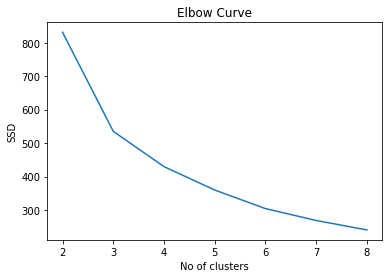

In [62]:
# Plotting Elbow curve or the Sum of Squared distances of points of each cluster from the centroid of the nearest cluster

ssd = []
range_n_clusters = np.arange(2,9)
for num_clusters in range_n_clusters : 
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(countries_scaled)
    ssd.append(kmeans.inertia_)
plt.plot(range_n_clusters,ssd)
plt.title('Elbow Curve');
plt.xlabel('No of clusters');
plt.ylabel('SSD');

#### Sihoutte Analysis

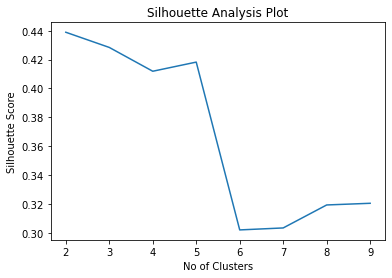

In [63]:
no_of_clusters = np.arange(2,10)
score = [] 

for n_cluster in no_of_clusters : 
    kmeans = KMeans(n_clusters=n_cluster, init='k-means++')
    kmeans = kmeans.fit(countries_scaled)
    labels = kmeans.labels_
    score.append(silhouette_score(countries_scaled,labels))
    

plt.title('Silhouette Analysis Plot')
plt.xlabel('No of Clusters')
plt.ylabel('Silhouette Score') 
plt.plot(no_of_clusters, score)
plt.show()

#### K=5

In [64]:
kmeans = KMeans(n_clusters = 5, random_state = 100)  
kmeans.fit(countries_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=100, tol=0.0001, verbose=0)

In [65]:
# determing the labels

kmeans.labels_

array([2, 0, 0, 2, 0, 0, 0, 3, 3, 0, 3, 3, 0, 0, 0, 3, 0, 2, 0, 0, 0, 2,
       0, 1, 0, 2, 2, 0, 2, 3, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 3, 3,
       3, 0, 0, 0, 0, 2, 2, 0, 0, 3, 3, 2, 2, 0, 3, 2, 3, 0, 0, 2, 2, 0,
       2, 0, 3, 0, 0, 0, 0, 1, 3, 3, 0, 3, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2,
       2, 0, 0, 1, 0, 2, 2, 0, 0, 2, 3, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       3, 3, 2, 4, 1, 0, 2, 0, 0, 0, 0, 0, 3, 1, 0, 0, 2, 0, 0, 2, 0, 0,
       2, 1, 0, 3, 2, 2, 3, 3, 0, 0, 2, 0, 3, 1, 0, 2, 0, 2, 2, 0, 0, 0,
       0, 2, 0, 3, 3, 3, 0, 0, 0, 0, 0, 2, 2])

In [66]:
# Copying the original dataframe to be exclusively used for k-means clustering purpose

countries_kmean = countries.copy()

In [67]:
# Assigning labels as cluster ids to the k-means clustering dataframe
countries_kmean['cluster_id'] = kmeans.labels_ 
countries_kmean.head()

,country,child_mort,health,income,inflation,life_expec,total_fer,gdpp,Trade Deficit,cluster_id
0,Afghanistan,90.2,41.9174,1610.0,9.44,56.2,5.82,553.0,192.997,2
1,Albania,16.6,267.8950,9930.0,4.49,76.3,1.65,4090.0,842.540,0
2,Algeria,27.3,185.9820,12900.0,16.10,76.5,2.89,4460.0,-312.200,0
3,Angola,119.0,100.6050,5900.0,22.40,60.1,6.16,3530.0,-684.820,2
4,Antigua and Barbuda,10.3,735.6600,19100.0,1.44,76.8,2.13,12200.0,1634.800,0


In [68]:
# Checking the number of countries for each cluster

countries_kmean['cluster_id'].value_counts()

0    84
2    46
3    28
1     8
4     1
Name: cluster_id, dtype: int64

#### For k = 6

In [69]:
kmeans_6 = KMeans(n_clusters = 6, random_state = 100)  
kmeans_6.fit(countries_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=100, tol=0.0001, verbose=0)

In [70]:
# determing the labels

kmeans_6.labels_

array([2, 0, 0, 2, 0, 0, 0, 3, 3, 0, 0, 0, 5, 0, 0, 3, 0, 2, 0, 5, 0, 5,
       0, 1, 0, 2, 2, 5, 2, 3, 0, 2, 2, 0, 0, 0, 5, 2, 5, 0, 2, 0, 3, 0,
       3, 0, 0, 5, 0, 2, 5, 0, 5, 3, 3, 5, 2, 0, 3, 5, 3, 0, 5, 2, 2, 5,
       2, 0, 3, 5, 5, 0, 5, 1, 3, 3, 0, 3, 0, 0, 5, 5, 1, 5, 5, 0, 0, 2,
       2, 0, 0, 1, 0, 5, 2, 0, 0, 2, 0, 5, 0, 5, 0, 5, 0, 0, 2, 5, 5, 5,
       3, 3, 2, 4, 1, 0, 5, 0, 0, 0, 5, 0, 3, 1, 0, 0, 5, 5, 0, 5, 0, 0,
       2, 1, 0, 3, 5, 5, 0, 3, 0, 0, 5, 0, 3, 1, 5, 2, 0, 5, 2, 5, 0, 0,
       5, 2, 0, 3, 3, 3, 0, 5, 5, 0, 0, 5, 2])

In [71]:
# Copying the original dataframe to be exclusively used for k-means clustering purpose

countries_kmean_6 = countries.copy()

In [72]:
# Assigning labels as cluster ids to the k-means clustering dataframe
countries_kmean_6['cluster_id'] = kmeans_6.labels_ 
countries_kmean_6.head()

,country,child_mort,health,income,inflation,life_expec,total_fer,gdpp,Trade Deficit,cluster_id
0,Afghanistan,90.2,41.9174,1610.0,9.44,56.2,5.82,553.0,192.997,2
1,Albania,16.6,267.8950,9930.0,4.49,76.3,1.65,4090.0,842.540,0
2,Algeria,27.3,185.9820,12900.0,16.10,76.5,2.89,4460.0,-312.200,0
3,Angola,119.0,100.6050,5900.0,22.40,60.1,6.16,3530.0,-684.820,2
4,Antigua and Barbuda,10.3,735.6600,19100.0,1.44,76.8,2.13,12200.0,1634.800,0


In [73]:
# Checking the number of countries for each cluster

countries_kmean_6['cluster_id'].value_counts()

0    67
5    42
2    26
3    23
1     8
4     1
Name: cluster_id, dtype: int64

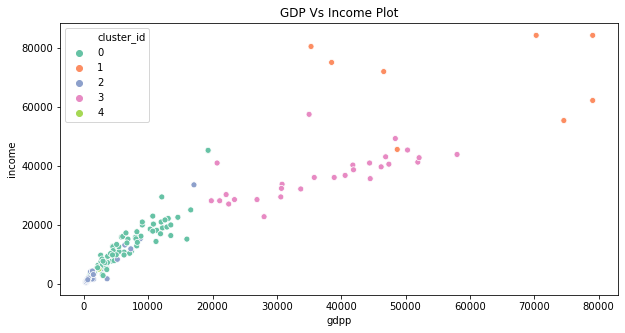

In [74]:
# Plot for income vs GDP for the 5 clusters

plt.figure(figsize = (10,5))
plt.title('GDP Vs Income Plot')
sns.scatterplot(x = 'gdpp', y = 'income', hue = 'cluster_id', data = countries_kmean, palette = 'Set2')
plt.show()

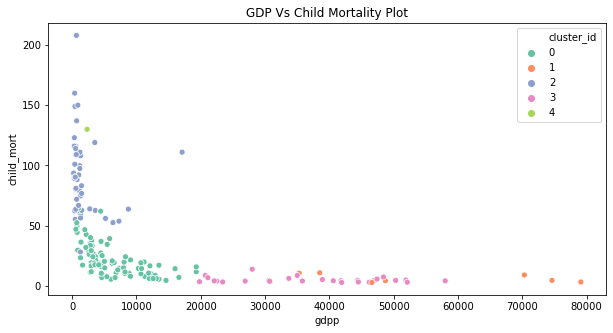

In [75]:
# Plot for GDP vs Child Mortality for the 5 clusters

plt.figure(figsize = (10,5))
plt.title('GDP Vs Child Mortality Plot')
sns.scatterplot(x = 'gdpp', y = 'child_mort', hue = 'cluster_id', data = countries_kmean, palette = 'Set2')
plt.show()

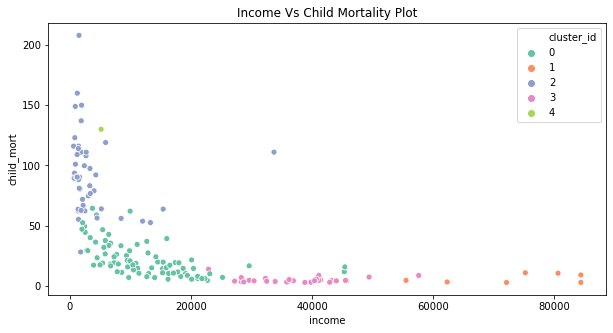

In [76]:
# Plot for Income vs Child Mortality for the 5 clusters

plt.figure(figsize = (10,5))
plt.title('Income Vs Child Mortality Plot')
sns.scatterplot(x = 'income', y = 'child_mort', hue = 'cluster_id', data = countries_kmean, palette = 'Set2')
plt.show()

### Cluster Profiling for K-Means Clustering

In [77]:
# Copying the scaled dataframe to be used futher for cluster profiling purpose now

countries_kmeans_profl = countries_scaled.copy()

countries_kmeans_profl['cluster_id'] = kmeans.labels_
countries_kmeans_profl['country'] = countries['country']
countries_kmeans_profl.head()

,child_mort,health,income,inflation,life_expec,total_fer,gdpp,Trade Deficit,cluster_id,country
0,1.291537,-0.566958,-0.851668,0.156035,-1.619705,1.903390,-0.702259,0.280341,2,Afghanistan
1,-0.538993,-0.440393,-0.386946,-0.314406,0.648831,-0.860816,-0.498726,0.488119,0,Albania
2,-0.272870,-0.486271,-0.221053,0.788991,0.671403,-0.038846,-0.477434,0.118736,0,Algeria
3,2.007831,-0.534088,-0.612045,1.387733,-1.179541,2.128769,-0.530950,-0.000459,2,Angola
4,-0.695682,-0.178410,0.125254,-0.604273,0.705262,-0.542634,-0.032042,0.741551,0,Antigua and Barbuda


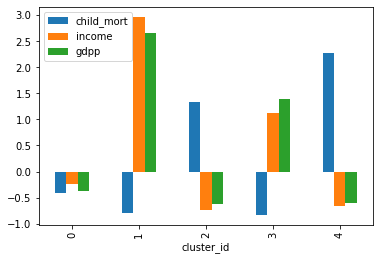

In [78]:
countries_kmeans_profl.drop(['country','health','inflation','life_expec','total_fer','Trade Deficit'],axis = 1).groupby('cluster_id').mean().plot(kind = 'bar')
plt.show()

In [79]:
# Let us view the countries for each clusters

#Cluster 0

cluster_kmean_0 = countries_kmean[countries_kmean['cluster_id']== 0]
print(cluster_kmean_0['country'].tolist())

['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Azerbaijan', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cambodia', 'Cape Verde', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Fiji', 'Georgia', 'Grenada', 'Guatemala', 'Guyana', 'Hungary', 'India', 'Indonesia', 'Iran', 'Iraq', 'Jamaica', 'Jordan', 'Kazakhstan', 'Kyrgyz Republic', 'Latvia', 'Lebanon', 'Libya', 'Lithuania', 'Macedonia, FYR', 'Malaysia', 'Maldives', 'Mauritius', 'Micronesia, Fed. Sts.', 'Moldova', 'Mongolia', 'Montenegro', 'Morocco', 'Myanmar', 'Nepal', 'Oman', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Romania', 'Russia', 'Samoa', 'Saudi Arabia', 'Serbia', 'Seychelles', 'Slovak Republic', 'Sri Lanka', 'St. Vincent and the Grenadines', 'Suriname', 'Tajikistan', 'Thailand', 'Tonga', 'Tunisia', 'Turkey', 'Turkmenistan', 'Ukraine', 'Uruguay',

In [80]:
#Cluster 1

cluster_kmean_1 = countries_kmean[countries_kmean['cluster_id']== 1]
print(cluster_kmean_1['country'].tolist())

['Brunei', 'Ireland', 'Kuwait', 'Luxembourg', 'Norway', 'Qatar', 'Singapore', 'Switzerland']


In [81]:
#Cluster 2

cluster_kmean_2 = countries_kmean[countries_kmean['cluster_id']== 2]
print(cluster_kmean_2['country'].tolist())

['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Equatorial Guinea', 'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Namibia', 'Niger', 'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone', 'Solomon Islands', 'South Africa', 'Sudan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Yemen', 'Zambia']


In [82]:
cluster_kmean_2.sort_values(by = ['gdpp','child_mort','income'], ascending = [True,False,True]).head()

,country,child_mort,health,income,inflation,life_expec,total_fer,gdpp,Trade Deficit,cluster_id
26,Burundi,93.6,26.7960,764.0,12.30,57.7,6.26,231.0,69.9468,2
88,Liberia,89.3,38.5860,700.0,5.47,60.8,5.02,327.0,240.3450,2
37,"Congo, Dem. Rep.",116.0,26.4194,609.0,20.80,57.5,6.54,334.0,28.3900,2
112,Niger,123.0,17.9568,814.0,2.55,58.8,7.49,348.0,93.6120,2
132,Sierra Leone,160.0,52.2690,1220.0,17.20,55.0,5.20,399.0,70.6230,2


In [83]:
#Cluster 3

cluster_kmean_3 = countries_kmean[countries_kmean['cluster_id']== 3]
print(cluster_kmean_3['country'].tolist())

['Australia', 'Austria', 'Bahamas', 'Bahrain', 'Belgium', 'Canada', 'Cyprus', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Iceland', 'Israel', 'Italy', 'Japan', 'Malta', 'Netherlands', 'New Zealand', 'Portugal', 'Slovenia', 'South Korea', 'Spain', 'Sweden', 'United Arab Emirates', 'United Kingdom', 'United States']


In [84]:
#Cluster 4

cluster_kmean_4 = countries_kmean[countries_kmean['cluster_id']== 4]
print(cluster_kmean_4['country'].tolist())

['Nigeria']


The countries that need immediate financial aids, as per K-means clustering, based on the parameters in order of importance - GDP, child mortality rate and net income per person:-

- Nigeria
- Burundi
- Liberia
- Congo Democratic Republic
- Niger
- Sierra Leone

### Hierarchical Clustering

In [85]:
# The scaled dataframe will be used, hence rechecking the same

countries_scaled.describe()

,child_mort,health,income,inflation,life_expec,total_fer,gdpp,Trade Deficit
count,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02
mean,-7.977650e-18,2.260334e-17,-2.592736e-17,8.310053e-17,3.722904e-17,5.451394e-17,8.044131e-17,6.182679e-17
std,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00
min,-8.822172e-01,-5.832538e-01,-9.075796e-01,-9.643549e-01,-4.339691e+00,-1.130475e+00,-7.207887e-01,-5.675614e+00
25%,-7.466684e-01,-5.464489e-01,-7.541989e-01,-5.691089e-01,-5.926565e-01,-7.646981e-01,-6.575476e-01,1.139858e-01
50%,-4.718403e-01,-4.101544e-01,-3.852698e-01,-2.288711e-01,2.876710e-01,-3.570275e-01,-4.659254e-01,2.471435e-01
75%,5.926524e-01,-4.327510e-02,3.319216e-01,2.805352e-01,7.052622e-01,6.174048e-01,7.441465e-02,3.844863e-01
max,4.221379e+00,4.119980e+00,3.771201e+00,9.142873e+00,1.333906e+00,3.010398e+00,3.816975e+00,9.978419e-01


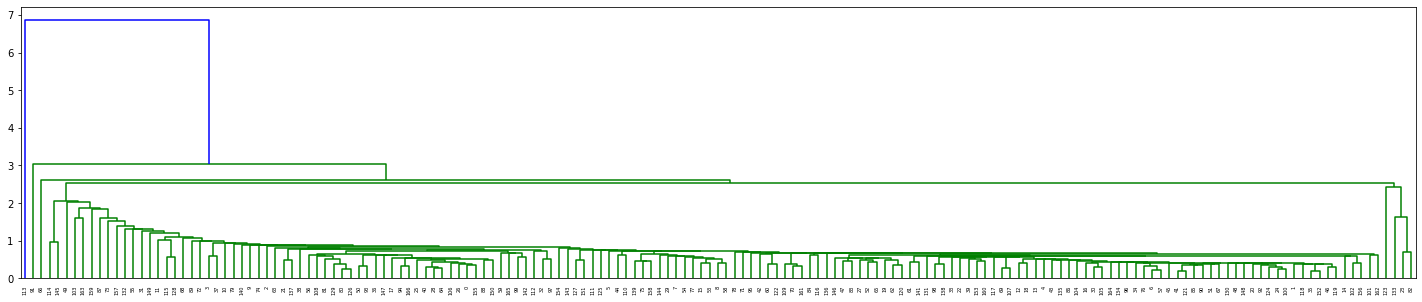

In [86]:
# Checking the dendrogram for single linkage

plt.figure(figsize = (25,5))
single_mergings = linkage(countries_scaled, method = 'single', metric = 'euclidean')
dendrogram(single_mergings)
plt.show()

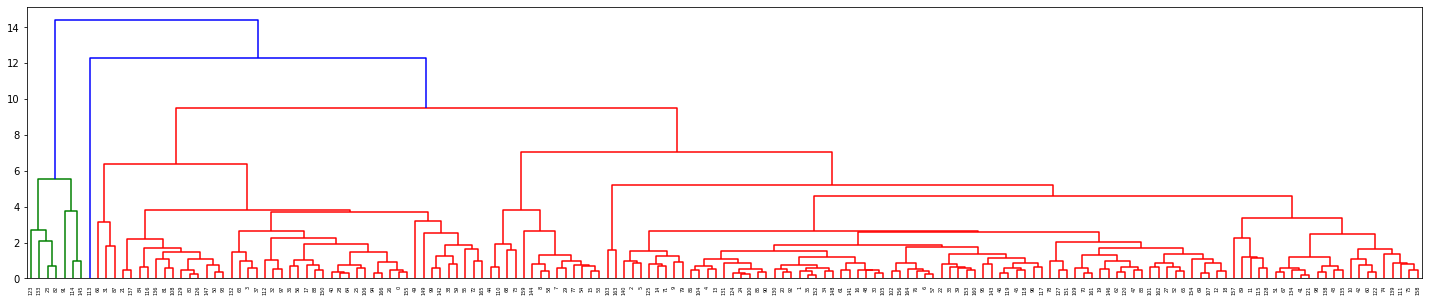

In [87]:
# Checking the dendrogram for complete linkage

plt.figure(figsize = (25,5))
complete_mergings = linkage(countries_scaled, method = 'complete', metric = 'euclidean')
dendrogram(complete_mergings)
plt.show()

In [88]:
# Going ahead with hiererachical clustering with 6 clusters

h_cluster_labels = cut_tree(complete_mergings, n_clusters=6).reshape(-1, )
h_cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 3, 1, 0, 0, 1, 0, 2, 1, 4, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 1, 1, 1, 0, 0, 1,
       4, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 0, 0, 3, 1, 0, 1, 1, 4,
       0, 1, 1, 3, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       2, 1, 0, 5, 3, 1, 0, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 3, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 3, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0])

In [89]:
# Copying the original dataframe to be exclusively used for hierarchical clustering purpose

countries_hcluster = countries.copy()

In [90]:
## Generating labels through hierarchical clustering using complete linkage and agglomerative approach 
countries_hcluster['h_cluster_id'] = h_cluster_labels
countries_hcluster.head()

,country,child_mort,health,income,inflation,life_expec,total_fer,gdpp,Trade Deficit,h_cluster_id
0,Afghanistan,90.2,41.9174,1610.0,9.44,56.2,5.82,553.0,192.997,0
1,Albania,16.6,267.8950,9930.0,4.49,76.3,1.65,4090.0,842.540,1
2,Algeria,27.3,185.9820,12900.0,16.10,76.5,2.89,4460.0,-312.200,1
3,Angola,119.0,100.6050,5900.0,22.40,60.1,6.16,3530.0,-684.820,0
4,Antigua and Barbuda,10.3,735.6600,19100.0,1.44,76.8,2.13,12200.0,1634.800,1


In [91]:
# Checking the number of countries for each cluster

countries_hcluster['h_cluster_id'].value_counts()

1    98
0    44
2    14
3     7
4     3
5     1
Name: h_cluster_id, dtype: int64

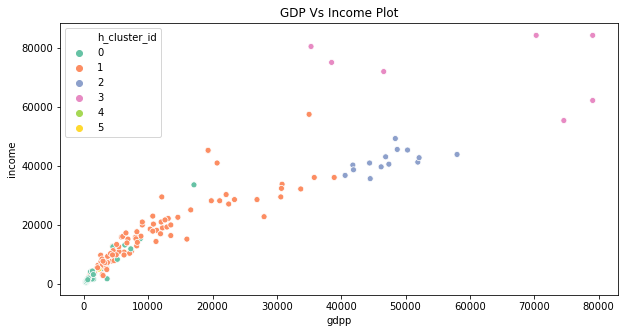

In [92]:
# Plot for income vs GDP for the 6 clusters

plt.figure(figsize = (10,5))
plt.title('GDP Vs Income Plot')
sns.scatterplot(x = 'gdpp', y = 'income', hue = 'h_cluster_id', data = countries_hcluster, palette = 'Set2')
plt.show()

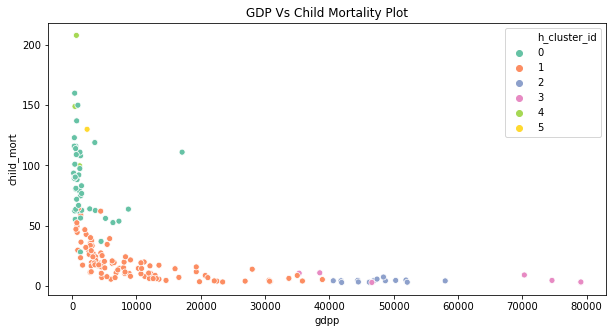

In [93]:
# Plot for GDP vs Child Mortality for the 6 clusters

plt.figure(figsize = (10,5))
plt.title('GDP Vs Child Mortality Plot')
sns.scatterplot(x = 'gdpp', y = 'child_mort', hue = 'h_cluster_id', data = countries_hcluster, palette = 'Set2')
plt.show()

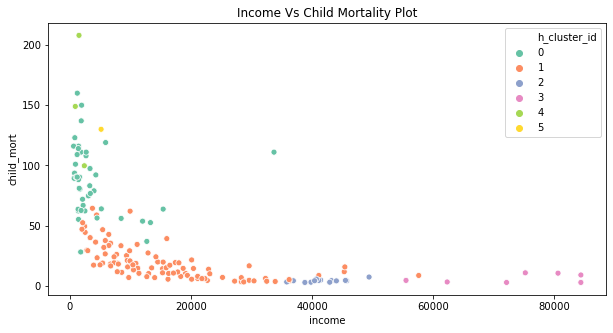

In [94]:
# Plot for Income vs Child Mortality for the 6 clusters

plt.figure(figsize = (10,5))
plt.title('Income Vs Child Mortality Plot')
sns.scatterplot(x = 'income', y = 'child_mort', hue = 'h_cluster_id', data = countries_hcluster, palette = 'Set2')
plt.show()

### Cluster Profiling for Hierarchical Clustering

In [95]:
# Copying the scaled dataframe to be used futher for cluster profiling purpose now

countries_hcluster_profl = countries_scaled.copy()

countries_hcluster_profl['h_cluster_id'] = h_cluster_labels
countries_hcluster_profl['country'] = countries['country']
countries_hcluster_profl.head()

,child_mort,health,income,inflation,life_expec,total_fer,gdpp,Trade Deficit,h_cluster_id,country
0,1.291537,-0.566958,-0.851668,0.156035,-1.619705,1.903390,-0.702259,0.280341,0,Afghanistan
1,-0.538993,-0.440393,-0.386946,-0.314406,0.648831,-0.860816,-0.498726,0.488119,1,Albania
2,-0.272870,-0.486271,-0.221053,0.788991,0.671403,-0.038846,-0.477434,0.118736,1,Algeria
3,2.007831,-0.534088,-0.612045,1.387733,-1.179541,2.128769,-0.530950,-0.000459,0,Angola
4,-0.695682,-0.178410,0.125254,-0.604273,0.705262,-0.542634,-0.032042,0.741551,1,Antigua and Barbuda


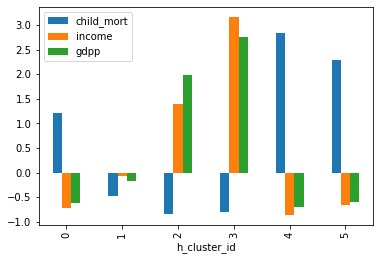

In [96]:
countries_hcluster_profl.drop(['country','health','inflation','life_expec','total_fer','Trade Deficit'],axis = 1).groupby('h_cluster_id').mean().plot(kind = 'bar')
plt.show()

In [97]:
# Let us view the countries for each hierarchical clusters

#Cluster 0

cluster_hc_0 = countries_hcluster[countries_hcluster['h_cluster_id']== 0]
print(cluster_hc_0['country'].tolist())

['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Equatorial Guinea', 'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Iraq', 'Kenya', 'Kiribati', 'Lao', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Namibia', 'Niger', 'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone', 'Solomon Islands', 'South Africa', 'Sudan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Yemen', 'Zambia']


In [98]:
cluster_hc_0.sort_values(by = ['gdpp','child_mort','income'], ascending = [True,False,True]).head()

,country,child_mort,health,income,inflation,life_expec,total_fer,gdpp,Trade Deficit,h_cluster_id
26,Burundi,93.6,26.7960,764.0,12.30,57.7,6.26,231.0,69.9468,0
88,Liberia,89.3,38.5860,700.0,5.47,60.8,5.02,327.0,240.3450,0
37,"Congo, Dem. Rep.",116.0,26.4194,609.0,20.80,57.5,6.54,334.0,28.3900,0
112,Niger,123.0,17.9568,814.0,2.55,58.8,7.49,348.0,93.6120,0
132,Sierra Leone,160.0,52.2690,1220.0,17.20,55.0,5.20,399.0,70.6230,0


In [99]:
#Cluster 1

cluster_hc_1 = countries_hcluster[countries_hcluster['h_cluster_id']== 1]
print(cluster_hc_1['country'].tolist())

['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cambodia', 'Cape Verde', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Fiji', 'Georgia', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hungary', 'India', 'Indonesia', 'Iran', 'Israel', 'Italy', 'Jamaica', 'Jordan', 'Kazakhstan', 'Kyrgyz Republic', 'Latvia', 'Lebanon', 'Libya', 'Lithuania', 'Macedonia, FYR', 'Malaysia', 'Maldives', 'Malta', 'Mauritius', 'Micronesia, Fed. Sts.', 'Moldova', 'Mongolia', 'Montenegro', 'Morocco', 'Myanmar', 'Nepal', 'New Zealand', 'Oman', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Samoa', 'Saudi Arabia', 'Serbia', 'Seychelles', 'Slovak Republic', 'Slovenia', 'South Korea', 'Spain', 'Sri Lank

In [100]:
#Cluster 2

cluster_hc_2 = countries_hcluster[countries_hcluster['h_cluster_id']== 2]
print(cluster_hc_2['country'].tolist())

['Australia', 'Austria', 'Belgium', 'Canada', 'Denmark', 'Finland', 'France', 'Germany', 'Iceland', 'Ireland', 'Japan', 'Netherlands', 'Sweden', 'United States']


In [101]:
#Cluster 3

cluster_hc_3 = countries_hcluster[countries_hcluster['h_cluster_id']== 3]
print(cluster_hc_3['country'].tolist())

['Brunei', 'Kuwait', 'Luxembourg', 'Norway', 'Qatar', 'Singapore', 'Switzerland']


In [102]:
#Cluster 4

cluster_hc_4 = countries_hcluster[countries_hcluster['h_cluster_id']== 4]
print(cluster_hc_4['country'].tolist())

['Central African Republic', 'Haiti', 'Lesotho']


In [103]:
#Cluster 5

cluster_hc_5 = countries_hcluster[countries_hcluster['h_cluster_id']== 5]
print(cluster_hc_5['country'].tolist())

['Nigeria']


The countries that need immediate financial aids, as per Hierarchical Clustering, using complete linkage and agglomerative approach, on the parameters in order of importance - GDP, child mortality rate and net income per person:-

- Nigeria
- Central African Republic
- Haiti
- Lesotho
- Burundi
- Liberia
- Congo Democratic Republic
- Niger
- Sierra Leone

** Conclusion **

After performing k-means clustering as well hierarchical clustering, and ranking based on low GDP, followed by high child mortality rate and low net income per person, the top 6 countries that require immediate financial assistance are:-

- Nigeria
- Burundi
- Liberia
- Congo Democratic Republic
- Niger
- Sierra Leone

In addition to these, immediate financial aids might also be considered for the following 3 countries as well:-

- Central African Republic
- Haiti
- Lesotho